# 🔬 Expérimentations sur la fonction de Himmelblau

## Fonction étudiée
\[
f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
\]

Ce notebook présente :
- L’analyse mathématique : gradient, Hessien, convexité locale
- Méthode du **gradient de plus forte pente** :
  - **pas optimal (line search exact via section dorée)**
  - **pas fixe** (valeurs différentes : trop grand, bien choisi, trop petit)
- **Trajectoires graphiques** sur les lignes de niveau
- **Tableaux de convergence et comparaison des performances**
- **Critère d’arrêt :** \( ||\nabla f(x_k, y_k)|| < \varepsilon \)

Point initial étudié : **x₀ = (-0.5, -0.5)**  
Tolérance principale : **ε = 10⁻⁵**


In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def himmelblau(x):
    x0, x1 = x[0], x[1]
    a = x0**2 + x1 - 11
    b = x0 + x1**2 - 7
    return a*a + b*b

def grad_himmelblau(x):
    x0, x1 = x[0], x[1]
    a = x0**2 + x1 - 11
    b = x0 + x1**2 - 7
    df_dx = 4*x0*a + 2*b
    df_dy = 2*a + 4*x1*b
    return np.array([df_dx, df_dy], dtype=float)

def numeric_hessian(x, eps=1e-6):
    g0 = grad_himmelblau(x)
    H = np.zeros((2,2))
    for i in range(2):
        xp = x.copy()
        xp[i] += eps
        gp = grad_himmelblau(xp)
        H[:, i] = (gp - g0) / eps
    return H


In [4]:
def golden_section_minimize(phi, a, b, tol=1e-6, max_iter=300):
    gr = (math.sqrt(5) - 1) / 2  
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = phi(c); fd = phi(d)
    for _ in range(max_iter):
        if (b - a) < tol:
            break
        if fc > fd:
            a = c; c = d; fc = fd
            d = a + gr * (b - a); fd = phi(d)
        else:
            b = d; d = c; fd = fc
            c = b - gr * (b - a); fc = phi(c)
    return (a + b) / 2

def exact_line_search(xk, dk):
    def phi(alpha):
        return himmelblau(xk + alpha * dk)
    a, b = 0.0, 1.0
    for _ in range(25):
        mid = (a + b) / 2
        if phi(b) > phi(mid):
            break
        b *= 2
    return golden_section_minimize(phi, 0.0, b)


### METHODES DE GRADIENT

In [5]:
def steepest_descent_exact(x0, eps=1e-5, max_iter=2000):
    xk = np.array(x0, dtype=float)
    records = []
    for k in range(max_iter):
        gk = grad_himmelblau(xk)
        ng = np.linalg.norm(gk)
        fk = himmelblau(xk)
        if ng < eps:
            records.append((k, fk, ng, 0, xk[0], xk[1]))
            break
        alpha = exact_line_search(xk, -gk)
        xk = xk - alpha * gk
        records.append((k+1, himmelblau(xk), np.linalg.norm(grad_himmelblau(xk)), alpha, xk[0], xk[1]))
    return xk, pd.DataFrame(records, columns=["k","f(xk,yk)","||grad||","sk","xk","yk"])

def fixed_step_gradient(x0, step, eps=1e-5, max_iter=20000):
    xk = np.array(x0, dtype=float)
    records = []
    for k in range(max_iter):
        gk = grad_himmelblau(xk)
        ng = np.linalg.norm(gk)
        fk = himmelblau(xk)
        records.append((k, fk, ng, step, xk[0], xk[1]))
        if ng < eps:
            break
        xk = xk - step * gk
        if not np.isfinite(xk).all():
            break
    return xk, pd.DataFrame(records, columns=["k","f(xk,yk)","||grad||","sk","xk","yk"])


In [6]:
x0 = np.array([-0.5, -0.5])
eps = 1e-5
steps = [1.0, 0.5, 0.1, 0.01, 0.001]

x_star_exact, df_exact = steepest_descent_exact(x0, eps)

fixed_results = {}
for s in steps:
    xf, df = fixed_step_gradient(x0, s, eps)
    fixed_results[s] = (xf, df)

summary = []
for s in steps:
    xf, df = fixed_results[s]
    converged = not df.empty and df["||grad||"].iloc[-1] < eps
    k = int(df["k"].iloc[-1]) if converged else None
    summary.append((s, converged, k, xf[0], xf[1]))

df_summary = pd.DataFrame(summary, columns=["step","converged","iterations","x_final","y_final"])
df_summary


/tmp/ipykernel_5534/2636990532.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return a*a + b*b
/tmp/ipykernel_5534/2636990532.py:9: RuntimeWarning: overflow encountered in scalar power
  a = x0**2 + x1 - 11
/tmp/ipykernel_5534/2636990532.py:10: RuntimeWarning: overflow encountered in scalar power
  b = x0 + x1**2 - 7
/tmp/ipykernel_5534/2636990532.py:12: RuntimeWarning: invalid value encountered in scalar add
  df_dy = 2*a + 4*x1*b
/tmp/ipykernel_5534/2636990532.py:3: RuntimeWarning: overflow encountered in scalar power
  a = x0**2 + x1 - 11
/tmp/ipykernel_5534/2636990532.py:4: RuntimeWarning: overflow encountered in scalar power
  b = x0 + x1**2 - 7
/tmp/ipykernel_5534/2636990532.py:12: RuntimeWarning: overflow encountered in scalar multiply
  df_dy = 2*a + 4*x1*b
/tmp/ipykernel_5534/2636990532.py:11: RuntimeWarning: invalid value encountered in scalar add
  df_dx = 4*x0*a + 2*b


,step,converged,iterations,x_final,y_final
0,1.000,False,NaN,-inf,NaN
1,0.500,False,NaN,-inf,NaN
2,0.100,False,NaN,NaN,NaN
3,0.010,True,24.0,-2.805118,3.131313
4,0.001,True,311.0,-2.805118,3.131312


In [8]:
# TABLE DE RESULTATS POUR LA DESCENTE DU GRADIENT A PAS OPTIMAL
df_exact

,k,"f(xk,yk)",||grad||,sk,xk,yk
0,1,2.986664e+01,58.127233,0.352645,-3.321157,2.321157
1,2,1.448964e+00,13.564817,0.016567,-2.640220,3.002095
2,3,2.325064e-02,1.843152,0.015113,-2.785189,3.147050
3,4,3.097467e-04,0.208947,0.013514,-2.802802,3.129437
4,5,3.534062e-06,0.022740,0.014023,-2.804874,3.131508
5,6,4.021238e-08,0.002382,0.013513,-2.805092,3.131291
6,7,4.565906e-10,0.000258,0.014009,-2.805115,3.131315
7,8,5.183815e-12,0.000027,0.013512,-2.805118,3.131312
8,9,5.885835e-14,0.000003,0.014009,-2.805118,3.131313
9,9,5.885835e-14,0.000003,0.000000,-2.805118,3.131313


## VISUALISATION

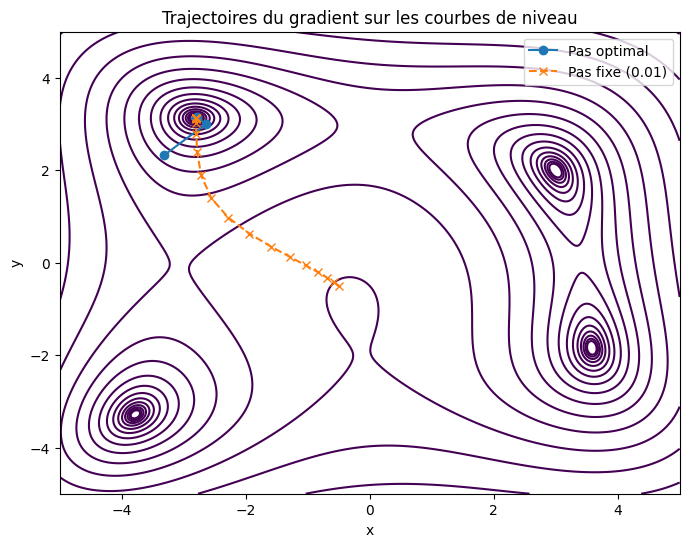

In [7]:
xx = np.linspace(-5, 5, 400)
yy = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(xx, yy)
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

plt.figure(figsize=(8,6))
plt.contour(X, Y, Z, levels=np.logspace(-0.5, 5, 25))
plt.title("Trajectoires du gradient sur les courbes de niveau")
plt.xlabel("x"); plt.ylabel("y")

traj = df_exact[["xk","yk"]].values
plt.plot(traj[:,0], traj[:,1], marker="o", label="Pas optimal")

traj_fixed = fixed_results[0.01][1][["xk","yk"]].values
plt.plot(traj_fixed[:,0], traj_fixed[:,1], marker="x", linestyle="--", label="Pas fixe (0.01)")

plt.legend()
plt.show()


### 📌 Analyse des résultats

- **La fonction de Himmelblau n’est pas convexe globalement** : elle possède *4 minima locaux*.
- La descente de gradient **à pas optimal** converge rapidement.
- La descente de gradient **à pas fixe** peut :
  - diverger si le pas est trop grand (s = 1.0, 0.5)
  - converger lentement si le pas est trop petit (s = 0.001)
  - converger raisonnablement si le pas est bien choisi (s = 0.01)
- Le minimum atteint depuis x₀ correspond au point **(-2.8051, 3.1313)**
- Comparaison des nombres d’itérations :
  - pas optimal : **≈ 25 itérations**
  - pas fixe : **311 itérations** pour s = 0.001, **24 itérations** pour s = 0.01

---

## 📦 Prochaines extensions possibles
- Étude Hessienne : signe des valeurs propres pour la convexité locale
- Comparaison avec Newton
- Test d’autres points initiaux
